# Notebook para testear herramientas

Combinar carta de observacion con fchart

Astroplan para planear segun altura y masa de aire

reportlab para generar el pdf de observacion

In [1]:
import fchart
import os

import math as m
import numpy as np
import matplotlib.pyplot as plt
import seaborn

from astropy.coordinates import SkyCoord
from astropy.coordinates import get_sun
from astropy.time import Time
from astropy import units as u
from astropy.table import Table
from astropy.table import Column
from astropy.io import ascii
from astroplan import FixedTarget

import conf as cf

%matplotlib inline

/home/bruno/.virtualenvs/alertreport/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
from astropy.utils.console import ProgressBar

In [3]:
plots = cf.plots
if not os.path.isdir(plots):
    os.mkdir(plots)

In [4]:
observatory = cf.observer

sunset_tonight = observatory.sun_set_time(cf.obs_time, which='next', horizon=-15*u.degree)
sunrise_tonight = observatory.sun_rise_time(cf.obs_time, which='next', horizon=-15*u.degree)

local_sunset = (sunset_tonight-3*u.hour).utc.iso
local_sunrise = (sunrise_tonight-3*u.hour).utc.iso


print 'tiempo local de crepusculo', local_sunset 
print 'tiempo local del alba', local_sunrise

If you need enough precision such that this matters (~<10 arcsec), you can
use the latest IERS predictions by running:

    >>> from astropy.utils import iers
    >>> iers.IERS.iers_table = iers.IERS_A.open(iers.IERS_A_URL)

 [astropy.coordinates.builtin_frames.utils]
If you need enough precision such that this matters (~<10 arcsec), you can
use the latest IERS predictions by running:

    >>> from astropy.utils import iers
    >>> iers.IERS.iers_table = iers.IERS_A.open(iers.IERS_A_URL)

 [astropy.coordinates.builtin_frames.utils]

>>> from astroplan import download_IERS_A
>>> download_IERS_A()
 [astroplan.utils]


tiempo local de crepusculo 2016-06-02 19:38:08.342
tiempo local del alba 2016-06-03 07:03:04.813


In [5]:
print "Tiempo sidereo en puesta del sol =",sunset_tonight.sidereal_time('mean', longitude=cf.longitude)
print "Tiempo sidereo en salida del sol =",sunrise_tonight.sidereal_time('mean', longitude=cf.longitude)

Tiempo sidereo en puesta del sol = 11h07m15.0546s
Tiempo sidereo en salida del sol = 22h34m04.0438s


In [6]:
def is_up_tonight(alpha, delta, sunrise, sunset, observatory):
    lat = observatory.location.latitude.degree
    circum = 90 - abs(lat)
    if abs(delta) > circum and np.sign(delta)==np.sign(lat):
        return True
    lon = observatory.location.longitude.degree
    lst_rise = sunrise.sidereal_time('mean', longitude=lon).degree
    lst_set = sunset.sidereal_time('mean', longitude=lon).degree
    
    if alpha%360 > (lst_set - 70)%360 and alpha%360 < (lst_rise + 70)%360:
        return True
    return False

In [7]:
def alpha_cuts(observation_time, horizon=-15*u.degree, min_height=45*u.degree):
    sun = get_sun(observation_time)
    horiz = horizon.to(u.degree)
    h = min_height.to(u.degree)
    
    lowest_alpha = (sun.ra - horiz + h)
    highest_alpha = (sun.ra + horiz - h)#.hourangle%24

    return (lowest_alpha.to(u.hourangle).value, highest_alpha.to(u.hourangle).value)

In [8]:
observatory.local_sidereal_time(Time.now(), 'mean')

/home/bruno/.virtualenvs/alertreport/local/lib/python2.7/site-packages/astropy/time/core.py:592: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif longitude == 'greenwich':


<Longitude 5.78131489902783 hourangle>

In [9]:
white_cat= cf.catalog

white_table = ascii.read(white_cat, delimiter=' ', format='commented_header')

circum_angle = abs(90.*u.degree - abs(observatory.location.latitude))

circum = abs(white_table['Dec']*u.degree - 90.*u.degree) > circum_angle + 90*u.degree

alpha_obs_min, alpha_obs_max = alpha_cuts(cf.obs_time)

dist_lim = 80.

In [10]:
near = white_table['Dist'] < dist_lim 
visible = white_table['App_Mag']< 19     # Apparent Magnitude cut
bright = white_table['Abs_Mag']< -17.5      # Absolute Magnitude cut
lim_dec = white_table['Dec']< 30. 

alfa_min = white_table['RA'] >  float(alpha_obs_min)       # Alpha cut 
alfa_max = white_table['RA'] <= float(alpha_obs_max)

if alpha_obs_max > alpha_obs_min:
    sample = white_table[near & visible & bright & lim_dec & ((alfa_min & alfa_max) | circum)]
else:
    sample = white_table[near & visible & bright & lim_dec & ((alfa_min | alfa_max) | circum)]


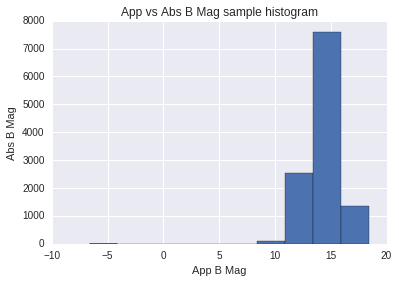

In [11]:
plt.hist(sample['App_Mag'])
plt.xlabel('App B Mag')
plt.ylabel('Abs B Mag')
plt.title('App vs Abs B Mag sample histogram')

plt.savefig(os.path.join(plots, 'appmag_sample_histogram.png'), dpi=300)

plt.show()

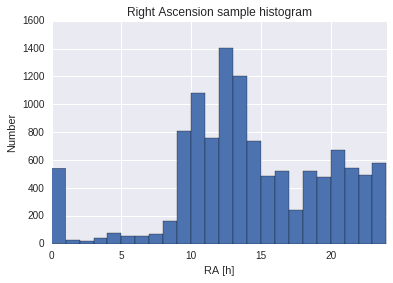

In [12]:
plt.hist(sample['RA'], bins=24)
plt.xlim((0,24))
plt.xlabel('RA [h]')
plt.ylabel('Number')
plt.title('Right Ascension sample histogram')

plt.savefig(os.path.join(plots, 'RA_sample_histogram.png'), dpi=300)

plt.show()

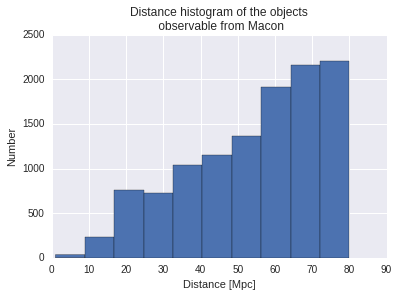

In [13]:
plt.hist(sample['Dist'], range=[1,dist_lim])
plt.title('Distance histogram of the objects\n observable from Macon')

plt.xlabel('Distance [Mpc]')
plt.ylabel('Number')

plt.savefig(os.path.join(plots, 'distance_histogram_sample.png'), dpi=300)

plt.show()

-2.54925682718 -0.551494373033


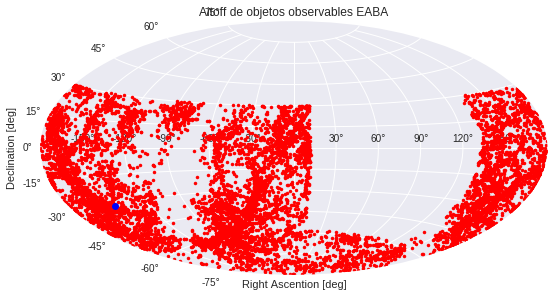

In [14]:
plt.figure(figsize=(10,10))
plt.subplot(211, projection="aitoff")
deg2rad=np.pi/180.

coord = SkyCoord(ra=sample['RA']*u.hourangle, dec=sample['Dec']*u.degree, frame='icrs')

mean_zenith_ra = np.mean(coord.ra.wrap_at(360*u.degree).radian)
if mean_zenith_ra > m.pi:
    mean_zenith_ra -= 2*m.pi
zenith_dec = observatory.location.latitude.radian

xg = coord.ra.wrap_at(180 * u.deg).radian
yg = coord.dec.radian

# we should avoid the galactic plane
plt.plot(xg,yg, "r.")
plt.plot(mean_zenith_ra, zenith_dec, 'bo')
print mean_zenith_ra, zenith_dec
plt.grid(True)
plt.title("Aitoff de objetos observables EABA")
plt.xlabel("Right Ascention [deg]")
plt.ylabel("Declination [deg]")
plt.savefig(os.path.join(plots, 'radec_aitoff_sample.png'), dpi=300)
plt.show()

In [15]:
import healpy as hp

In [16]:
aligo_alert_data_file=os.path.join('./.',"skymap.fits")
NSIDE=512 #2048
aligo_banana = hp.read_map(aligo_alert_data_file)

NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [17]:
from astropy.io import fits
hdr1 = fits.getheader(aligo_alert_data_file)
hdr1

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


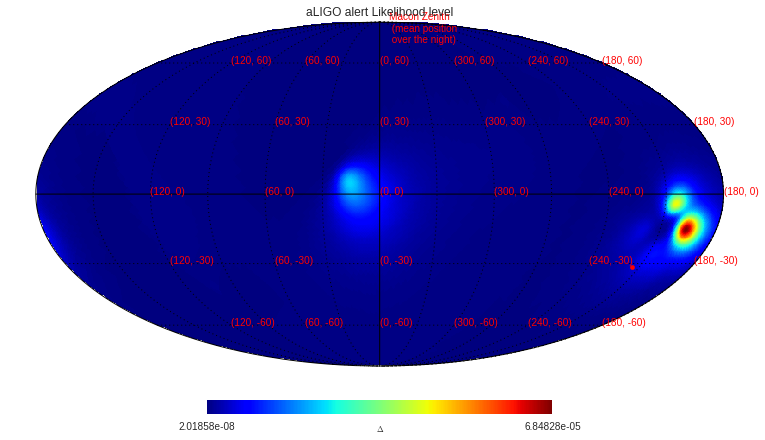

In [18]:
# plot the banana map
fig = plt.figure(2, figsize=(10, 10))
hp.mollview(aligo_banana, title='aLIGO alert Likelihood level', flip="astro",
            unit='$\Delta$', fig=2)
fig.axes[1].texts[0].set_fontsize(8)

mean_zenith_ra = np.mean(coord.ra.wrap_at(360*u.degree).degree)

zenith_dec = observatory.location.latitude.degree

hp.projscatter(mean_zenith_ra, zenith_dec, lonlat=True, color="red")
hp.projtext(mean_zenith_ra, zenith_dec,
            'Macon Zenith\n (mean position\n over the night)', lonlat=False, color="red")
for ra in range(0,360,60):
    for dec in range(-60,90,30):
        if not (ra == 300 and dec == -30):
                hp.projtext(ra,dec,'({}, {})'.format(ra,dec), lonlat=True, color='red')

hp.graticule()

plt.savefig(os.path.join(plots, 'allsky_likelihoodmap.png'), dpi=300)
plt.show()

[213.93834290764852, -31.598300000000002]
50.5891087121 129.410891288 -39.4108912879 39.4108912879
The interval between parallels is 10 deg 0.00'.
The interval between meridians is 4 deg 0.00'.


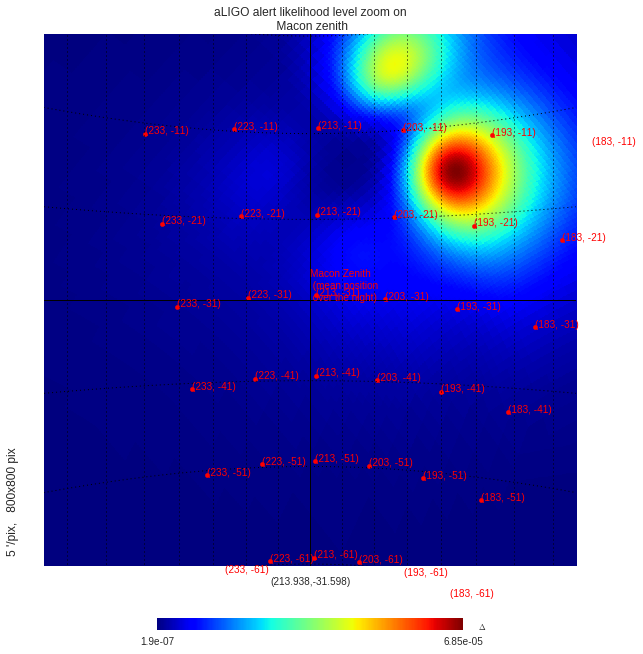

In [19]:
# plot the banana map
fig = plt.figure(2, figsize=(10, 10))
rot=[mean_zenith_ra, zenith_dec]
#rot2 = [mean_zenith_ra*180./m.pi +180, zenith_dec*180./m.pi]
print rot
hp.gnomview(aligo_banana, rot=rot, 
            title='aLIGO alert likelihood level zoom on\n Macon zenith', flip="astro",
            unit='$\Delta$', fig=2, xsize=800, reso=5)
fig.axes[1].texts[0].set_fontsize(8)

hp.projscatter(rot, lonlat=False, color="red")
hp.projtext(rot[0], rot[1],
            'Macon Zenith\n (mean position\n over the night)', lonlat=True, color="red")

for ra in range(int(mean_zenith_ra)-30, int(mean_zenith_ra)+30, 10):
    for dec in range(int(zenith_dec)-30, int(zenith_dec)+30, 10):
        hp.projscatter(ra, dec, lonlat=True, color="red")
        hp.projtext(ra, dec, '({}, {})'.format(ra,dec), lonlat=True, color='red')

hp.graticule()

plt.savefig(os.path.join(plots, 'gnomom_view_Macon_likelihoodmap.png'), dpi=300)

plt.show()

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


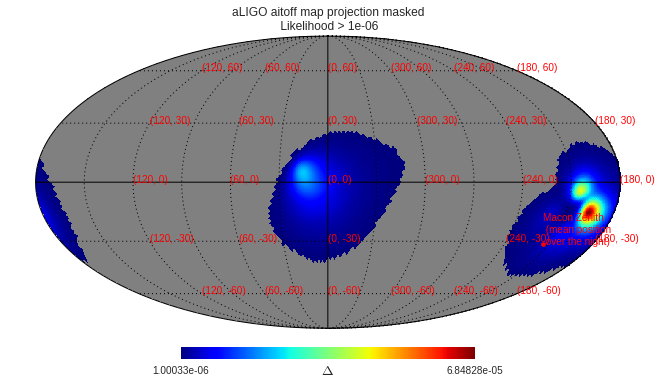

In [20]:
likehood_cut=0.000001 #ut level for mask buildup

aligo_alert_map_high_like = np.logical_not(aligo_banana < likehood_cut)
map_lik_masked = hp.ma(aligo_banana)
map_lik_masked.mask = np.logical_not(aligo_alert_map_high_like)

hp.mollview(map_lik_masked.filled(), 
            title='aLIGO aitoff map projection masked\n Likelihood > {}'.format(likehood_cut),
            unit='$\Delta$', fig=2)
hp.graticule()
hp.projscatter(mean_zenith_ra, zenith_dec
               , lonlat=True, color="red")
hp.projtext(mean_zenith_ra, zenith_dec,
            'Macon Zenith\n (mean position\n over the night)', lonlat=True, color="red")

for ra in range(0,360,60):
    for dec in range(-60,80,30):
        if not (ra == 300 and dec == -30):
            hp.projtext(ra,dec,'({}, {})'.format(ra,dec), lonlat=True, color='red')

plt.savefig(os.path.join(plots, 'allsky_likelihoodmap_masked.png'), dpi=300)
plt.show()

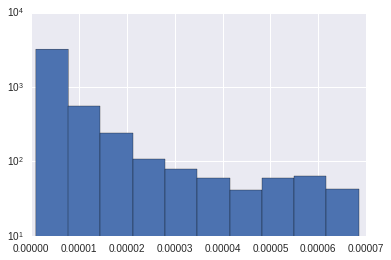

In [21]:
deg2rad = m.pi/180.

phis = list(sample['RA']*15.*deg2rad)
thetas = list(m.pi/2. - sample['Dec']*deg2rad)

def interp_filter(theta, phi):
    return hp.pixelfunc.get_interp_val(aligo_alert_map_high_like, 
                                       theta, phi, nest=False)

def interp(theta, phi):
    return hp.pixelfunc.get_interp_val(aligo_banana, 
                                       theta, phi, nest=False)

interps_filter = np.asarray(map(interp_filter, thetas, phis))

clipped = np.where(interps_filter > 0.2)

interps = np.asarray(map(interp, thetas, phis))

targets = sample[clipped[0]]

target_liks = interps[clipped[0]]

plt.hist(target_liks, log=True)
plt.show()


In [22]:
targets['Likelihoods'] = target_liks

4479


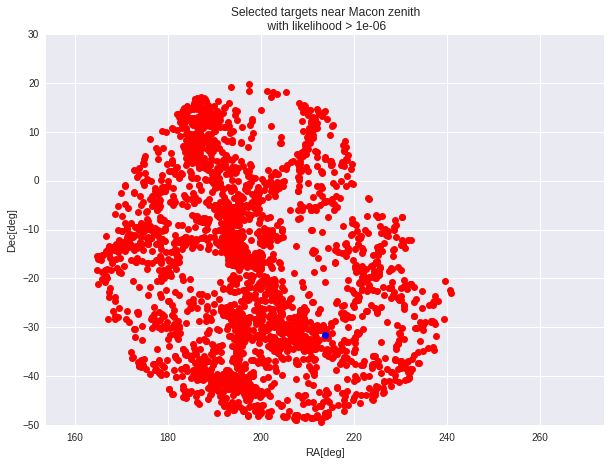

In [23]:
print len(targets)

plt.figure(figsize=(10,7))
plt.rcParams.update({"font.size":12})
plt.plot(targets['RA']*15.,targets['Dec'], "ro")
plt.plot(mean_zenith_ra, zenith_dec, 'bo')
plt.xlim(mean_zenith_ra-60, mean_zenith_ra+60)
plt.title("Selected targets near Macon zenith\n with likelihood > {}".format(likehood_cut))
plt.xlabel("RA[deg]")
plt.ylabel("Dec[deg]")
#plt.grid()
plt.savefig(os.path.join(plots, "selected_targets_Ra_dec.png"), dpi=300)
plt.show()

In [24]:
len(targets)

4479

In [25]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.coordinates import FK5

RAJ2016 = []
DecJ2016 = []
RA = []
Dec = []
with ProgressBar(len(targets), ipython_widget=True) as bar:
    for row in targets:
        coord=SkyCoord(ra=row['RA']*u.hourangle, dec=row['Dec']*u.degree, frame='icrs')
        precessed=coord.transform_to(FK5(equinox='J2016.3'))

        RAJ2016.append(precessed.to_string('hmsdms').split()[0])
        DecJ2016.append(precessed.to_string('hmsdms').split()[1])

        strcoord = coord.to_string('hmsdms')
        RA.append(strcoord.split()[0])
        Dec.append(strcoord.split()[1])
        #print i, coord.to_string('hmsdms'), targetLik[ind], targetMag[ind], RAJ2015[i], DecJ2015[i], name2[ind]
        bar.update()

In [26]:
targets['RAJ2016'] = RAJ2016
targets['DecJ2016'] = DecJ2016
targets['RAJ2000'] = RA
targets['DecJ2000'] = Dec

In [27]:
targets.rename_column('App_Mag', 'AppMag')
targets.rename_column('Abs_Mag', 'AbsMag')
targets.rename_column('Maj_Diam_a', 'MajDiamA')
targets.rename_column('Min_Diam_b', 'MinDiamB')
targets.rename_column('err_Maj_Diam','ErrMajDiam')
targets.rename_column('err_Min_Diam','ErrMinDiam')
targets.rename_column('err_Dist', 'ErrDist')
targets.rename_column('err_App_Mag', 'ErrAppMag')
targets.rename_column('err_Abs_Mag', 'ErrAbsMag')
targets.rename_column('err_b/a', 'Errb/a')

In [30]:
#targets.sort(['RAJ2000','Likelihoods'])
targets.sort(['Likelihoods','RAJ2000'])
top_targets = targets[0:4]

In [31]:
targets_plan = []
rises = [] #np.empty(len(top_targets), dtype='float')
sets = [] #np.empty(len(top_targets), dtype='float')
i = 0
with ProgressBar(len(top_targets), ipython_widget=True) as bar:
    for row in top_targets:
        coordinates = SkyCoord(row['RA']*u.degree, row['Dec']*u.degree, frame='icrs')
        obj = FixedTarget(coord=coordinates, name=row['Name'])
        targets_plan.append(obj)
        rise_time = observatory.target_rise_time(cf.obs_time, obj)
        set_time = observatory.target_set_time(cf.obs_time, obj)
        if rise_time.jd != -999.0: 
            rises.append(rise_time.jd)
        if set_time.jd != -999.0: 
            sets.append(set_time.jd)
        i += 1
        bar.update()

In [32]:
targcol = Column(targets_plan, name='planTargets')
risecol = Column(rises, name='RiseTime')
setcol = Column(sets, name='SetTime')

top_targets.add_column(targcol)
top_targets.add_column(risecol)
top_targets.add_column(setcol)

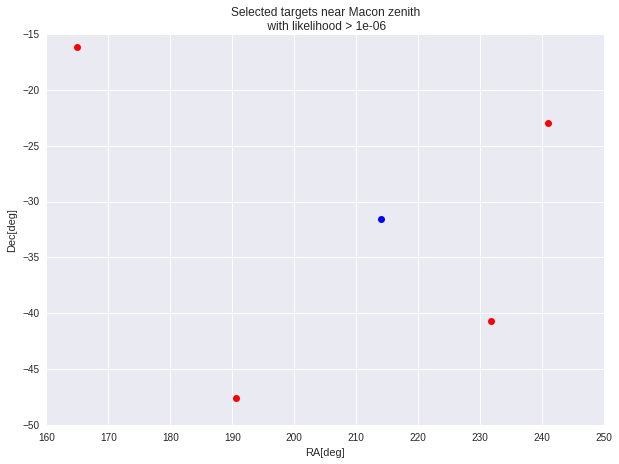

In [33]:
plt.figure(figsize=(10,7))
plt.rcParams.update({"font.size":14})
plt.plot(top_targets['RA']*15.,top_targets['Dec'], "ro")
plt.plot(mean_zenith_ra, zenith_dec, 'bo')
#plt.xlim(mean_zenith_ra-60, mean_zenith_ra+60)
plt.title("Selected targets near Macon zenith\n with likelihood > {}".format(likehood_cut))
plt.xlabel("RA[deg]")
plt.ylabel("Dec[deg]")
#plt.grid()
plt.savefig(os.path.join(plots, "selected_targets_Ra_dec.png"), dpi=300)
plt.show()

(array([ 1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([ 2457542.28997063,  2457542.29932143,  2457542.30867224,
         2457542.31802304,  2457542.32737385,  2457542.33672465,
         2457542.34607546,  2457542.35542626,  2457542.36477706,
         2457542.37412787,  2457542.38347867]),
 <a list of 10 Patch objects>)

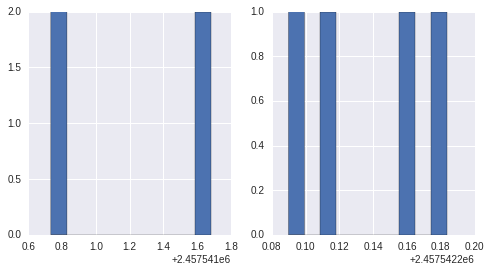

In [34]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.hist(rises)

plt.subplot(122)
plt.hist(sets)

<function matplotlib.pyplot.savefig>

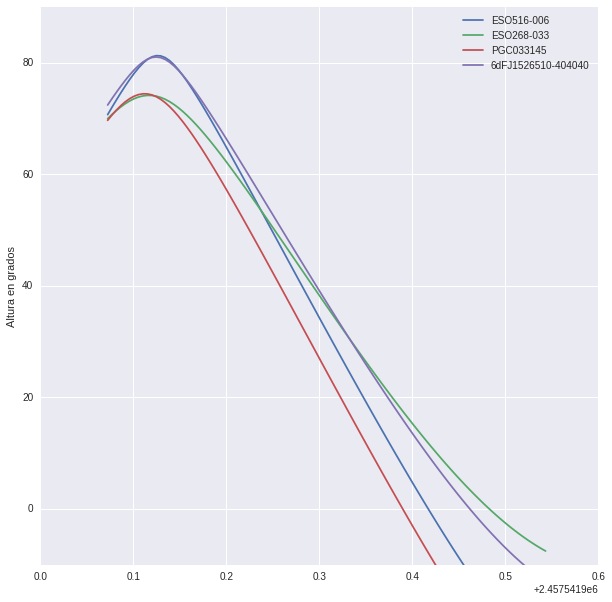

In [35]:
from astroplan.plots import plot_airmass
from astropy.coordinates import AltAz

plt.figure(figsize=(10,10))
plt.rcParams.update({"font.size":14})
delta = (sunset_tonight - sunrise_tonight)
deltas = np.arange(100)*delta/100.

legend = []

for row in top_targets:
    tgt = row['planTargets']
    coords = tgt.coord
    tgt_altazs = coords.transform_to(AltAz(obstime=sunset_tonight+deltas,location=observatory.location))

    plt.plot(sunset_tonight.value + np.array(deltas.value), tgt_altazs.alt.degree, label=row['Name'])
    

plt.ylabel('Altura en grados')
plt.ylim(-10,90)
plt.legend(loc=1) #(legend, 'upleft')
plt.savefig

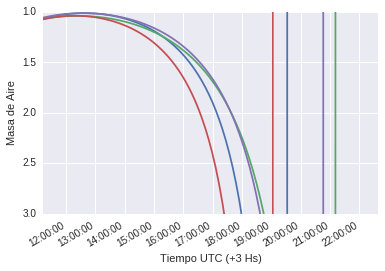

In [36]:
center = sunset_tonight + delta/2.
observe_time = center + np.linspace(-delta.value/2., delta.value/2., 100)*u.day

for tgt in targets_plan:
    plot_airmass(tgt, observatory, observe_time)

plt.xlabel('Tiempo UTC (+3 Hs)')
plt.ylabel('Masa de Aire')
#plt.ylim(-100,100)

### Choose one target order a query

In [37]:
from astroquery.skyview import SkyView

from retrying import retry

@retry(stop_max_attempt_number=4)
def download_dss(pos):
    path = SkyView.get_images(position = pos, survey='DSS', radius=20*u.arcmin, pixels=(900,900))
    return path

In [40]:
from kapteyn import maputils

for row in top_targets:
    
    plots = os.path.abspath(plots)
    target_dir = os.path.join(plots,'targets/'+row['Name'])
    if not os.path.exists(target_dir): #or not os.path.isdir(target_dir):
        os.mkdir(target_dir)
    
    pos = row['RAJ2000'] +' '+row['DecJ2000']
    print '(alfa, delta)', pos
    try:
        path = download_dss(pos)
    except:
        pass
    image0 = path[0]
    image0.writeto(os.path.join(target_dir,'DSS_image.fits'), clobber=True)
    
    f = maputils.FITSimage(os.path.join(target_dir,'DSS_image.fits'))
    fig = plt.figure(figsize=(10,10))
    frame = fig.add_subplot(1,1,1)
    annim = f.Annotatedimage(frame, cmap='gray_r')
    annim.Image()
    annim.Colorbar()
    grat=annim.Graticule()
    grat.setp_axislabel(fontsize=14)
    grat.setp_ticklabel(fontsize=14)
    annim.plot()
    annim.interact_imagecolors()
    annim.Marker(pos='AC', marker='x', markersize=30, color='g', 
             markeredgewidth=4, alpha=0.7)

    plt.savefig(os.path.join(target_dir, 'identification_chart.png'), dpi='figure',format='png', 
                bbox_inches='tight')
    fig.clear()

(alfa, delta) 16h03m53.316s -22d56m49.884s
(alfa, delta) 12h42m29.736s -47d33m29.268s
(alfa, delta) 11h00m04.86s -16d06m22.104s
(alfa, delta) 15h26m50.964s -40d40m39.684s


In [41]:
top_targets

PGC,Name,RA,Dec,Type,AppMag,MajDiamA,ErrMajDiam,MinDiamB,ErrMinDiam,b/a,Errb/a,PA,AbsMag,Dist,ErrDist,ErrAppMag,ErrAbsMag,Likelihoods,RAJ2016,DecJ2016,RAJ2000,DecJ2000,planTargets,RiseTime,SetTime
float64,str28,float64,float64,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,unicode14,unicode15,unicode13,unicode14,object,float64,float64
56899.0,ESO516-006,16.06481,-22.94719,4.6,13.94,0.549,0.177,0.489,nan,0.89,0.105,nan,-20.18,64.375,9.656,0.47,0.47,9.53722925579e-07,16h04m51.5198s,-22d59m27.7749s,16h03m53.316s,-22d56m49.884s,"<FixedTarget ""ESO516-006"" at SkyCoord (ICRS): (ra, dec) in deg (16.06481, -22.94719)>",2457541.73471,2457542.31747
42684.0,ESO268-033,12.70826,-47.55813,4.9,12.95,1.443,0.465,0.274,nan,0.19,0.022,nan,-21.45,72.944,10.942,0.26,0.27,9.59014719789e-07,12h43m24.3046s,-47d38m50.2244s,12h42m29.736s,-47d33m29.268s,"<FixedTarget ""ESO268-033"" at SkyCoord (ICRS): (ra, dec) in deg (12.70826, -47.55813)>",2457542.64729,2457542.38348
33145.0,PGC033145,11.00135,-16.10614,-3.0,14.85,1.022,0.329,0.286,nan,0.28,0.033,nan,-19.62,55.444,8.317,0.3,0.31,9.60466802161e-07,11h00m53.3639s,-16d11m37.8379s,11h00m04.86s,-16d06m22.104s,"<FixedTarget ""PGC033145"" at SkyCoord (ICRS): (ra, dec) in deg (11.00135, -16.10614)>",2457541.7342,2457542.28997
4076983.0,6dFJ1526510-404040,15.44749,-40.67769,NaN,15.28,nan,nan,nan,nan,nan,nan,nan,-18.83,64.486,14.187,0.48,0.49,9.64805315453e-07,15h27m55.8214s,-40d44m01.4745s,15h26m50.964s,-40d40m39.684s,"<FixedTarget ""6dFJ1526510-404040"" at SkyCoord (ICRS): (ra, dec) in deg (15.44749, -40.67769)>",2457542.68361,2457542.36235
